## Neural Machine Translation using Tensorflow & Keras by implementing Bahdanau Attention on an Encoder-Decoder (seq2seq) model

## Beam Search for effective Inference and model evaluation using BLEU metric

### For this notebook, please ensure you have tensorflow library installed (my version==2.4.0). The languages to be translated in this tutorial are from English to French.

Note: Some knowledge on RNN-LSTM Models and Object Oriented Programming employed in Deep Learning Models is assumed

In [1]:
## Importing some relevant libraries

from tensorflow.keras import Model, Input, Sequential

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Layer, Add, GRU, \
                                    Activation, Softmax, Concatenate, TimeDistributed

from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time

import pandas as pd
import numpy as np

import unicodedata
import re

### Section 1 - Data Processing

The dataset has been taken from - http://www.manythings.org/bilingual/

**Read the file 'spa.txt' that contains some English phrases/sentences and their translations in French**

In [2]:
df = pd.read_csv('fra.txt', sep='\t', header=None)

df.rename(columns={0:'eng', 1:'fra'}, inplace=True)

**Initialize functions that would process on the text**

In [3]:
# Note - Taken Directly from Tensorflow NMT Tutorial (with some modifications)

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


# Process on the sentence/phrase
def preprocess_sentence(w):
    
    # Convert the text from unicode to ascii
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # Removes any leading or trailing spaces
    w = w.strip()

    # Perhaps the most crucial point in processing -
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    # Return the processed text
    return w

In [4]:
# Applying the transformations to the text

df['fra_p'] = df['fra'].apply(lambda x: preprocess_sentence(x))
df['eng_p'] = df['eng'].apply(lambda x: preprocess_sentence(x))

df.drop([2], axis=1, inplace=True)

df.isnull().sum()

eng      0
fra      0
fra_p    0
eng_p    0
dtype: int64

In [5]:
# We will limit the number of datapoints here. Feel free to increase/decrease this number
limiter = 50000

df = df.iloc[:limiter, :]

df.reset_index(drop=True, inplace=True)

In [6]:
# A view of how the dataframe looks like
df

,eng,fra,fra_p,eng_p
0,Go.,Va !,<start> va ! <end>,<start> go . <end>
1,Go.,Marche.,<start> marche . <end>,<start> go . <end>
2,Go.,Bouge !,<start> bouge ! <end>,<start> go . <end>
3,Hi.,Salut !,<start> salut ! <end>,<start> hi . <end>
4,Hi.,Salut.,<start> salut . <end>,<start> hi . <end>
...,...,...,...,...
49995,Tom lied to all of us.,Tom nous a à tous menti.,<start> tom nous a a tous menti . <end>,<start> tom lied to all of us . <end>
49996,Tom lied to everybody.,Tom a menti à tout le monde.,<start> tom a menti a tout le monde . <end>,<start> tom lied to everybody . <end>
49997,Tom liked what he saw.,Tom a aimé ce qu'il a vu.,<start> tom a aime ce qu il a vu . <end>,<start> tom liked what he saw . <end>
49998,Tom liked what he saw.,Tom aima ce qu'il vit.,<start> tom aima ce qu il vit . <end>,<start> tom liked what he saw . <end>


### Section 2 - Data Tokenization

**The processed text will be index-tokenized**

This means that for two texts such as -

1. I am here
2. He is here right now

the tokenized form would be -

1. [1, 2, 3, 0, 0]
2. [4, 5, 3, 6, 7]

Basically, the tokenized form would replace the word with a unique number that would represent that word.

- Notice the padding done at the end of sentence 1 (two 0's added). This will be done based on the maximum length of a sentence in a particular language

- Notice the repetiton of 3 in both tokenized forms which represent the word 'here' being repeated

In [7]:
# Function Initializing and Fitting on text
def create_tokenizer(lines):
    
    # Initialize tokenizer
    tokenizer = Tokenizer()
    
    # Fit the tokenizer on the text provided
    tokenizer.fit_on_texts(lines)
    
    # Return the tokenizer
    return tokenizer

# Creating tokenizer instances for English text
tokenizer_input = create_tokenizer(df['eng_p'])

# Creating tokenizer instances for French text
tokenizer_output = create_tokenizer(df['fra_p'])

In [8]:
# Function to compute maximum length of tokenized forms
def max_length(lines):
    
    # Compute the maximum length amongst all sentences in text
    return max([len(s.split()) for s in lines])

# Storing the maximum length for English
length_input = max_length(df['eng_p'])

# Storing the maximum length for French
length_output = max_length(df['fra_p'])

In [9]:
# We will also need the number of unique tokenization there are in any text. 
# This just computes the number of unique words found in the text

# For English
vocab_size_input = len(tokenizer_input.word_index) + 1

# For French
vocab_size_output = len(tokenizer_output.word_index) + 1

In [10]:
# Function that will tokenize and pad the text
def encode_text(tokenizer, lines, length):
    
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    
    return padded

# Apply the tokenization and padding on English Text
lang_input = encode_text(tokenizer_input, df['eng_p'], length_input)

# Apply the tokenization and padding on French Text
lang_output = encode_text(tokenizer_output, df['fra_p'], length_output)

In [11]:
# Let's store our tokenized and processed text (model ready data) as a pickle file

import pickle

with open("./lang_eng_fra.pkl", 'wb') as f:
    pickle.dump(lang_input, f, protocol=4)

with open("./lang_fra_eng.pkl", 'wb') as f:
    pickle.dump(lang_output, f, protocol=4)

In [12]:
# This is a by-pass to let the model make use of more gpu memory when needed. I had to use it as it was throwing me an error
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# The best training device for this model would be to use gpu. CPU will also work but may take a lot more time in training

### Section 3 - Defining the Model

**Perhaps the most difficult part to comprehend**

**Note - This notebook employs only one hidden layer per encoder and decoder**

Let's start with initializing some model parameters below

In [13]:
# The number of sentences/phrases to be sent at a time to the model
batch_size = 32

# The source language's tokenized text will be embedded with this length
inp_embed_size = 128
# Number of hidden cells in the LSTM layer that learns sequences of source language
inp_lstm_cells = 256

# The target language's tokenized text will be embedded with this length
tar_embed_size = 128
# Number of hidden cells in the LSTM layer that learns sequences of target language
tar_lstm_cells = 256

# Number of attention units (will discuss about it now)
attention_units = 256

#### Let us build up the concept slowly. Starting discussion with an Encoder-Decoder translation model **without any attention mechanism**

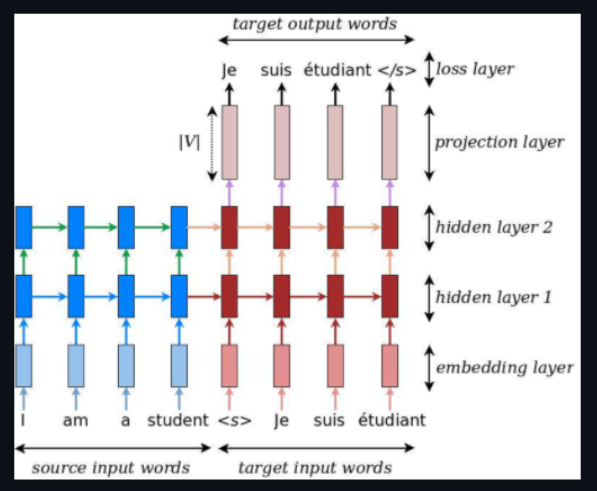

The blue cells denote the encoder and the red cells denote the decoder layers.

After the embedding layers embed each word of the source and target text, the encoder (blue hidden) layer learns the sequences in the source text as well as the final states of encoder from this layer are fed to the decoder (red hidden) layer that learns the sequences of translation along with the source states from the encoder.

The decoder layer then makes a projection layer which spits out a prediction vector of size V (vocabulary size of target language). The maximum probability value of this vector denotes the word that the model is predicting which is judged against what should be produced as a loss function.

Notice the \<s\> at the start of target input words which is the first word fed to the decoder model (representing the start of decoding) and the prediction at this point is the first word of translation. The last word of target input spits out \</s\> that would denote the end of translation.

As noted earlier, we have employed only one hidden layer in this notebook.

**Teacher Forcing:**

We will implement teacher forcing during training. This means that the model is fed with the translated word as an input to the decoder and that too in a sequential manner. In summary, it is the technique where the target word is passed as the next input to the decoder. Note that this won't and can not be implemented during inference

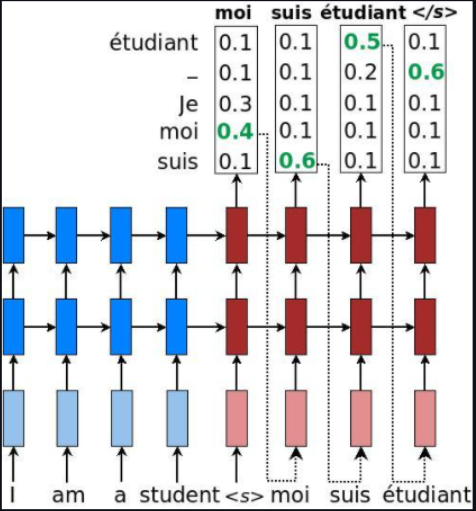

The inference, i.e. translating once the model has been trained, would be a little different. Let's see how below-

Everything is the same except we don't know the target input to be fed to the model when you would be inferring (teacher forcing above).

In this case, the first prediction of \<s\> (moi) is fed as an input of next target word to the model the produce the next translated word. The sequence continues until we hit \</s\> where the translation stops.

Above figure is a type of greedy decoding since we are only looking at the word with the highest probability in the prediction vector. This is very basic seq2seq model. Adding the attention mechanism to it greatly enhances its performance. If you have understood the above architecture, move below to understand **Attention**

#### Let's now start with an Encoder-Decoder translation model **with Bahdanau attention mechanism**

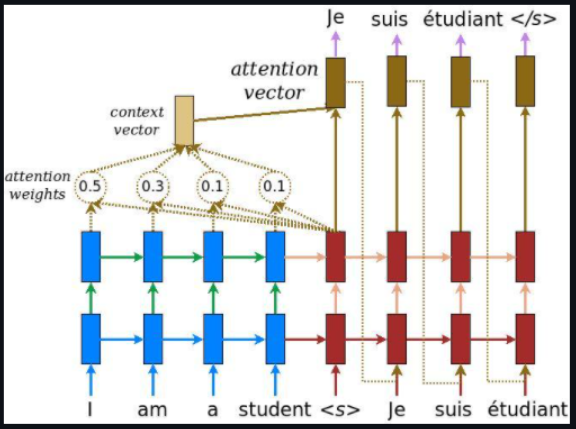

You will notice the addition of 'attention weights', 'context vector' and finally the attention vector to the above discussed model.

The calculation of the above hinges on the below formulae :-

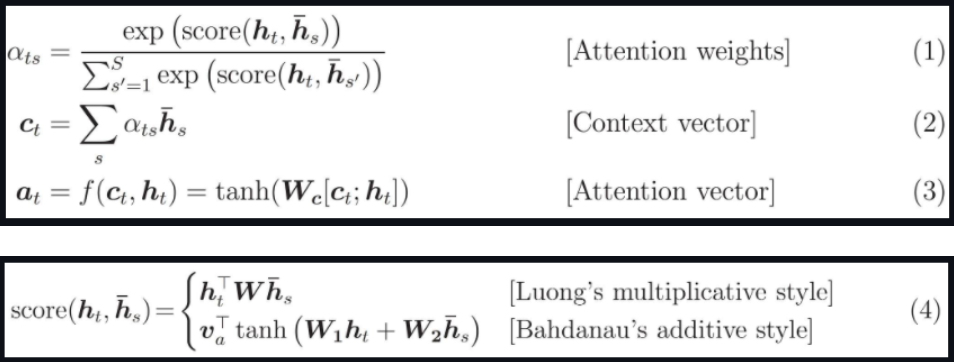

The attention computation happens at every decoder time step. It consists of the following stages:

1. The current target hidden state is compared with all of the source states to derive attention weights.
2. Based on the attention weights, we compute a context vector as the weighted average of the source states.
3. Then we combine the context vector with the current target hidden state to yield the final attention vector
4. The attention vector is fed as an input to the next time step (input feeding)

The way of comparing the source states with the current target hidden state has been researched and Bahdanau' additive style has been employed in this notebook (**Formula 4** in above figure). There are other comparative measures such as Luong's multiplicative style as well as their variations and combinations. 

The comparison gives out a score when each source hidden state is compared with the current target hidden state. This score is fed to a softmax layer (**Formula 1**) that measures the score of the current hidden state against each source hidden state (which are the attention weights).

The weights are then assessed with the source states so that the model focuses on source input words where it should focus in translating the current target input (**Formula 2**). This produces a context vector that contains information where the context lies in the input sequence to translate the current word

The context vector is concatenated with the current target hidden state and then activated to get an attention vector (**Formula 3**) that encompasses all information of source input and for target input - everything upto the current target input state.

Also, the hidden state obtained during computation of attention vector is added as an input to the next word in target input so that the prior information is passed on in a sequential manner to its embedding and subsequent learning.

Notice the teacher forcing here during training when the target word is passed as the next input to the decoder. Again, as told earlier, it is an aspect only built-in during the training and the inference will act without it.

During the inference, everything is same except that teacher-forcing isn't implemented and the translated 'prediction' word from the model itself is fed as the next input to the decoder

I believe that was a lot to take in. Here are some articles I referred when I tried to understand it all and I hope that these will be able to get you some more in-depth knowledge and insights -

1. Base Article - https://www.tensorflow.org/tutorials/text/nmt_with_attention
2. Understanding Attention - https://github.com/tensorflow/nmt#intermediate
3. Understanding Types of Attention - https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

**Let's begin with building the model**

An Object-oriented approach is applied as the libaries don't have predefined layers that can incorporate this architecture. There could be a way using backend Keras but I believe it would also require some modifications that can be done using a Class inheriting the backend classes.

##### Encoder Model

This should be quite simple to understand. A single lstm layer takes input from the embedding layer that embeds the tokenized text given as an input to the model

In [14]:
class Encoder(Model):
    
    # Intialize Model's Instance's parameters
    # the encoder parameters intialized above are taken as the default parameters for encoder
    
    def __init__(self, inp_vocab_size, inp_embed_size, inp_lstm_cells, batch_size, inp_len):
        
        super(Encoder, self).__init__()
        
        self.inp_embed_size = inp_embed_size # Initializing size that the Embedding layer outputs
        self.inp_vocab_size = inp_vocab_size # Initializing the vocabulary size of source text
        self.inp_lstm_cells = inp_lstm_cells # Initializing the number of hidden cells in the lstm layer
        self.batch_size = batch_size         # Initializing the batch size
        self.inp_len = inp_len               # Initializing the maximum input length of any tokenized source text
        
       
        # Initializing an Embedding layer here
        
        # vocab_size given as the range within which it has to work
        # embed_size denoting the embedding output size
        self.enc_embedding = Embedding(self.inp_vocab_size, self.inp_embed_size, trainable=True)
        
        # Initializing an LSTM layer here
        
        # lstm_cells denotes the number of hidden cells inside the layer
        # return_sequences and return_state give out output of LSTM cell and its state at each time step
        self.lstm = LSTM(self.inp_lstm_cells, return_sequences=True, return_state=True)
      
    
    # Use 'call' function to make the Encoder Model produce actions that you would want it to
    
    # Takes the source input sequence as first input and a hidden state as the second input
    def call(self, inp_sequence, hidden_sequence):
        
        # First, call the embedding layer defined above to embed the source input sequence
        emb_output = self.enc_embedding(inp_sequence)
        # emb_output shape = [batch_size, max_source_inp_length, embedding_size]
        
        # Second, call the lstm layer defiend above to use the embeddings to store information
        # of the sequence with the initial state provided
        inp_lstm_output, state_h, state_c = self.lstm(emb_output, initial_state = hidden_sequence)   
        # lstm_output shape = [batch_size, max_source_inp_length, lstm_cells]
        # state_h shape = [batch_size, lstm_cells]
        
        # 1. lstm_output contains output of the LSTM from all time steps
        # 2. state_h contains output from the last time step
        # 3. state_c contains the information of the state of the LSTM at the last time step
        
        # return all the outputs at each time step (lstm_output) and the output at the last time step (state_h)
        return inp_lstm_output, state_h

    
    # This function is meant to initialize the hidden weights of the lstm layer
    
    def initialize_hidden_states(self):
        
        # There are two sets of initializations made - for the hidden cell input (h at t-1) and hidden cell state (c at t-1)
        return [tf.zeros([self.batch_size, self.inp_lstm_cells]), tf.zeros([self.batch_size, self.inp_lstm_cells])]

In [15]:
# Initialize an instance of the Encoder model above with the defined parameters

enc_model = Encoder(inp_vocab_size=vocab_size_input, inp_embed_size=inp_embed_size, inp_lstm_cells=inp_lstm_cells, 
                    batch_size=batch_size, inp_len=length_input)


# Test the working below

# Initialize hidden states
initialized_hidden_states = enc_model.initialize_hidden_states()

# Feed an input and see if the model produces an output
enc_out, enc_state = enc_model(lang_input[:batch_size], initialized_hidden_states)

##### Attention Layer

Here, we define the attention layer that takes all the outputs of the encoder and the current hidden state to generate attention weights and context vector. These will be subsequently utilized by the Decoder Model

Refer Formula 1, 2 & 4 to understand the working below. Formula 3 will be applied in the Decoder Model

In [16]:
class Attention(Layer):
            
                                        # Default parameters supplied (same as encoder)
    def __init__(self, attention_units, bs = batch_size, inp_len = length_input):
        
        super(Attention, self).__init__()
        
        self.W1 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.W2 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.V = Dense(1)                 # Initialize a Dense layer with neurons = 1
        
        self.batch_size = bs
        self.inp_len = length_input
    
    
    # This function is executed when an instance of this class is called
    
    # hidden = output of the current target state
    # output = all outputs of the encoder model
    def call(self, hidden, output):
        
        # the shape of the hidden input is extended i.e. from [batch_size, tar_lstm_cells] to [batch_size, 1, tar_lstm_cells]
        hidden_extended = tf.expand_dims(hidden, axis=1)
        
        # hidden_extended shape = [batch_size, 1, target_lstm_cells]
        # output shape = [batch_size, max_source_inp_length, source_lstm_cells]
        
        # Formula 4 i.e. Bahdanau Attention applied here to generate a score
        score = self.V(tf.nn.tanh(self.W1(hidden_extended) + self.W2(output)))
        # score shape = [batch_size, max_source_inp_length, 1]                                     #### check this
        
        # Formula 1 applied here to get the attention weights (notice axis = 1) 
        # since we have to compute a weight to each source input, the softmax is applied at axis=1 of score
        atn_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape = [batch_size, max_source_inp_length, 1]                         #### check this
        
        # A part of Formula 2 is applied where we multiple the attention weights with the outputs from the encoder model
        context_vector = atn_weights*output
        # context_vector shape = [batch_size, max_source_inp_length, source_lstm_cells]

        # The second part of Formula 2 where the multiplied product is summed against each source input
        # the axis=1 here has the same reasoning wherein we want to sum the values to get one vector for each source input
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector shape = [batch_size, source_lstm_cells]
        
        # return the context_vector and the attention_weights generated from the above operations
        return context_vector, atn_weights

##### Decoder Model

This is the most difficult architectural formulation of the model. Please look at the operations step-by-step

Both Bahdanau Attention and Decoder operations will be performed in this class to generate predictions. Formula 3 of the Attention mechanism discussed above will be implemented in this class as well

In [17]:
class Decoder(Model):
                    
                        # Providing parameters to decoder to generate layers
    def __init__(self, tar_embed_size, tar_vocab_size, tar_lstm_cells, attention_units, 
                 batch_size=batch_size, tar_len=length_output):
        
        super(Decoder, self).__init__()
        
        self.tar_embed_size = tar_embed_size # Initializing size that the Embedding layer outputs
        self.tar_vocab_size = tar_vocab_size # Initializing the vocabulary size of target text
        self.tar_lstm_cells = tar_lstm_cells # Initializing the number of hidden cells in the lstm layer
        self.batch_size = batch_size         # Initializing the batch size
        self.tar_len = tar_len               # Initializing the maximum input length of any tokenized target text
        self.attention_units = attention_units  # Initializing the number of units for the attention layer
        
        
        # Initializing an Embedding layer here
        
        # vocab_size given as the range within which it has to work
        # embed_size denoting the embedding output size
        self.dec_embedding = Embedding(self.tar_vocab_size, self.tar_embed_size, trainable=True)
        
        
        # Initializing an LSTM layer here
        
        # lstm_cells denotes the number of hidden cells inside the layer
        # return_sequences and return_state give out output of LSTM cell and its state at each time step
        self.lstm = LSTM(self.tar_lstm_cells, return_sequences=True, return_state=True)
        
        
        # Initializing an Attention layer here
        
        # attention_units denotes the number of neurons inside the layer
        self.attention = Attention(self.attention_units)
        
        
        # Initializing a Final Dense layer here
        
        # takes the same number or neurons as the vocabulary size of target text (producing a probability value for each word)
        self.final_layer = Dense(self.tar_vocab_size)

    
    # This call function is executed when an instance of this class is called
    
    # x = input to the decoder
    # hidden = output of the current target state
    # enc_output = all outputs of the encoder model
    def call(self, x, hidden, enc_output):
        
        # Applying the attention on hidden state of current target state and output from the encoder
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # context_vector shape = [batch_size, lstm_cells]
        # attention_weights shape = [batch_size, max_source_inp_length, 1]                         #### check this
        
        # Apply embeddings on the decoder input
        emb_output = self.dec_embedding(x)
        # emb_output shape = [batch_size, 1, embedding_size]
        
        # Performing part 1 of Formula 3 i.e. concatenation of context_vector and embedding output
        # context_vector shape is expanded first from [batch_size, source_lstm_cells] to [batch_size, 1, source_lstm_cells]
        x_context = tf.concat([tf.expand_dims(context_vector, axis=1), emb_output], axis=-1)
        # x_context shape = [batch_size, 1, lstm_cells+embedding_size]
        
        # Performing part 2 of Formula 3 i.e. activating it using as LSTM layer
        # Running the x_context through as LSTM layer that learns the sequences
        tar_lstm_output, tar_state_h, tar_state_c = self.lstm(x_context)
        # lstm_output shape = [batch_size, 1, lstm_cells]
        # state_h shape = [batch_size, lstm_cells]
        # state_c shape = [batch_size, lstm_cells]
        
        # The output is reshaped here in order to be fed to the final Dense layer
        tar_lstm_output_reshaped = tf.reshape(tar_lstm_output, shape=(-1, tar_lstm_output.shape[2]))
        # tar_lstm_output_reshaped shape = [batch_size, lstm_cells]
        
        # the final dense layer outputs a score for each word that may be considered as a prediction
        # for this reason, the complete target vocabulary is provided as number of neurons to this layer
        word_prob = self.final_layer(tar_lstm_output_reshaped)
        # word_prob shape = [batch_size, tar_vocab_size]

        # return the word predictions, last output from the decoder LSTM and the attention_weights
        return word_prob, tar_state_h, attention_weights

In [18]:
# Initialize an instance of the Decoder model above with the defined parameters

dec_model = Decoder(tar_embed_size=tar_embed_size, tar_vocab_size=vocab_size_output, tar_lstm_cells=tar_lstm_cells, 
                    attention_units=attention_units)

# Test the working below

dec_out, dec_state, atn_w = dec_model(tf.random.uniform((batch_size, 1)), enc_state, enc_out)

We are finally finished with setting up the Encoder and Decoder Model Classes

We can now begin setting up the loss function that will be monitored and reduced as the training progresses

In [19]:
# Adam optimizer will be implemented
optimizer = tf.keras.optimizers.Adam()

# An instance of the SparseCategoricalCrossentropy Loss with some required arguments that define how it has to perform
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# from_logits - unnormalized predictions passed (notice no softmax applied in the final layer)
# reduction = 'none' - returns the full array of the per-sample losses in the batch

In [20]:
# Initializing Loss function here
def loss_function(real, pred):
    
    # mask shape = [batch_size, ]
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # tf.math.equal returns True when values are equal to 0
                                                #tf.math.logical_not inverses the above (True<==>False)
        
    # The mask is meant to only take losses where there is an actual word that exists i.e.
    # not for cases where the padding has been placed to put 0 as a token

    # Compute loss using real and pred values    
    loss_ = loss_object(real, pred)
    # loss_ shape = [batch_size, ]
    
    # casts mask variable as a tf loss type variable
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # multiplies loss with mask (this operation will nullify any loss values where the padding has been put in place)
    loss_ *= mask
    # loss_ shape = [batch_size, ]

            # tf.reduce_mean computes the mean loss
    return tf.reduce_mean(loss_)

In [21]:
# Some other helper functions initialized below


# Function for shuffling the dataset for fitting the model with (implemented every epoch)
def shuffler(lang_inp, lang_out):
    
    n_elem = lang_inp.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)
    
    return lang_inp[indices], lang_out[indices]


# Function for generating a batch of data from the dataset provided
def generator(batch_number, lang_input, lang_output):
    
    if len(lang_input) <= batch_number*batch_size+batch_size:
        
        return (lang_input[batch_number*batch_size:], 
            lang_output[batch_number*batch_size:])
    
    return (lang_input[batch_number*batch_size: batch_number*batch_size+batch_size], 
            lang_output[batch_number*batch_size: batch_number*batch_size+batch_size])

#### Section 4 - Training the Model

Now that all parts of model building are finished, we can now proceed with training the model

In [22]:
# Function to call for training every batch

@tf.function  # Decorator - Compiles the function below into a callable TensorFlow graph
def train_step(inp, targ, enc_hidden): # runs for a single batch
    
    # initialize loss as 0 for the batch
    loss = 0
    
    # uses gradient tape so that differentiation takes place accordingly to update gradient and weights
    with tf.GradientTape() as tape:
        
        # get the output from encoder model
        enc_output, enc_hidden = enc_model(inp, enc_hidden)
        # enc_output shape = [batch_size, max_source_inp_length, lstm_cells]
        # enc_hidden shape = [batch_size, lstm_cells]
        
        # assign enc_hidden state as dec_hidden state
        dec_hidden = enc_hidden
        # dec_hidden shape = [batch_size, lstm_cells]
        
        # for each sample in batch take starting index as the same as 'start' taken from target tokenizer
        # use the above as the first input to the decoder model
        dec_input = tf.expand_dims([tokenizer_output.word_index['start']] * batch_size, 1)
        # dec_input shape = [batch_size, 1]

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]): # run for the complete length of target outputs
            
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output)
          # predictions shape = [batch_size, tar_vocab_size]
          # dec_hidden shape = [batch_size, lstm_cells]
          # targ[:, t] shape = [batch_size, ]
            
          # compute loss for the word predicted (t) after the previous word supplied for all samples
          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing (take the next word as an input to the decoder model)
          dec_input = tf.expand_dims(targ[:, t], 1)
          # dec_input shape = [batch_size, 1]
    
    # computing batch loss by dividing the total loss with the length of target
    batch_loss = (loss / int(targ.shape[1]))

   
    # As the loss has now been computed, let's notify the model to optimize the gradients
    
    # collecting all variables to compute gradient
    variables = enc_model.trainable_variables + dec_model.trainable_variables
    
    # compute the gradients. (loss is differentiated against variables)
    gradients = tape.gradient(loss, variables)
    
    # Applies gradients to variables
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [23]:
# The training will now be carried here

EPOCHS = 20 # Initialize the number of epochs to run

# To store loss of each epoch
loss_history = []

# Computing number of batches
number_of_batches = lang_input.shape[0]//batch_size
    
# Splitting the dataset at the end to form full batches
lang_input_split = lang_input[:number_of_batches*batch_size]
lang_output_split = lang_output[:number_of_batches*batch_size]
    
    
for epoch in range(EPOCHS):
    
    start = time.time()
    
    # initialize hidden states of encoder for the epoch
    enc_hidden = enc_model.initialize_hidden_states()

    # total loss is 0 for the epoch
    total_loss = 0
        
    # Shuffle the dataset here
    lang_inp, lang_out = shuffler(lang_input_split, lang_output_split)
    
    # run for all batches of inputs and targets
    for batch_number in range(number_of_batches):
        
        # Generate the batch to be sent to the model for training
        inp, targ = generator(batch_number, lang_inp, lang_out)

        # apply the train step function declared earlier and get the loss for the batch
        batch_loss = train_step(inp, targ, enc_hidden)

        # add the batch loss to total loss for the epoch
        total_loss += batch_loss

        # printing some summaries inside the loop
        if batch_number % 200 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch_number,
                                                       batch_loss.numpy()))
    
    # Appending the total loss of the epoch here
    loss_history.append(total_loss / number_of_batches)

    
    # printing epoch summaries here
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / number_of_batches))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
        
    # The below set of checks are made to ensure that loss is reducing with each epoch. It it is not, break out of the loop
    if epoch >= 2:
        if loss_history[-1] >= loss_history[-2]: #patience is 0
            print("breaking now as loss isn't reducing")
            break

Epoch 1 Batch 0 Loss 2.8848
Epoch 1 Batch 200 Loss 1.6666
Epoch 1 Batch 400 Loss 1.4412
Epoch 1 Batch 600 Loss 1.4718
Epoch 1 Batch 800 Loss 1.1865
Epoch 1 Batch 1000 Loss 1.1658
Epoch 1 Batch 1200 Loss 1.0912
Epoch 1 Batch 1400 Loss 1.0155
Epoch 1 Loss 1.3403
Time taken for 1 epoch 254.22027111053467 sec

Epoch 2 Batch 0 Loss 1.0919
Epoch 2 Batch 200 Loss 0.8893
Epoch 2 Batch 400 Loss 0.9480
Epoch 2 Batch 600 Loss 0.8825
Epoch 2 Batch 800 Loss 0.9154
Epoch 2 Batch 1000 Loss 0.9693
Epoch 2 Batch 1200 Loss 0.8597
Epoch 2 Batch 1400 Loss 0.8312
Epoch 2 Loss 0.8918
Time taken for 1 epoch 219.46919178962708 sec

Epoch 3 Batch 0 Loss 0.6166
Epoch 3 Batch 200 Loss 0.6848
Epoch 3 Batch 400 Loss 0.6949
Epoch 3 Batch 600 Loss 0.6947
Epoch 3 Batch 800 Loss 0.6166
Epoch 3 Batch 1000 Loss 0.7079
Epoch 3 Batch 1200 Loss 0.7098
Epoch 3 Batch 1400 Loss 0.6337
Epoch 3 Loss 0.6891
Time taken for 1 epoch 223.3612380027771 sec

Epoch 4 Batch 0 Loss 0.5241
Epoch 4 Batch 200 Loss 0.5809
Epoch 4 Batch 400 L

#### Section 5 - Inference from the Model

**Firstly, let's store model weights**

In [24]:
enc_model.save_weights('enc_eng_fra_weights.h5')

In [25]:
dec_model.save_weights('dec_eng_fra_weights.h5')

As described earlier, the inference will happen with feeding the predicted value from the previous time step to the next time step. The inference will be performed below

### Greedy Search

**Greedy Search is the most basic inference algorithm. It takes the word with the highest probability at each output from the decoder input. This word is then fed to the next time step of the decoder to predict the next word until we hit the 'end' signal**

In [26]:
# Function for processing the sentence first before its translation

def preprocessing_sentence(w):
    
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = 'start ' + w + ' end'
    return w

In [27]:
# Function to translate the sentence

def evaluate(sentence):

    # process the sentence first
    sentence = preprocessing_sentence(sentence)
    
    # transform the sentence to its tokenized form
    inputs = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    
    # Pad the tokenized inputs with 0
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=length_input,
                                                             padding='post')
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(inputs)
  
    # initialize to store the result
    result = ''
    
    # initialize hidden weights of encoder
    hidden = [tf.zeros([1, inp_lstm_cells]), tf.zeros([1, inp_lstm_cells])]
    
    # get the output of the encoder using initialized weights
    enc_out, enc_hidden = enc_model(inputs, hidden)

    # initialize decoder hidden weights same as encoder hidden weights
    dec_hidden = enc_hidden
    
    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer_output.word_index['start']], 0)
    
    # run for the maximum length of target language
    for t in range(length_output):
        
        # get the output of the encoder based on the outputs provided from encoder
        predictions, dec_hidden, attention_weights = dec_model(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # get the argument(token) for the word that is given maximum probability score by the model
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # check if 'end' is hit on the outputted word from decoder model
        if tokenizer_output.index_word[predicted_id] == 'end':
            return result, sentence
        
        # Get the word based on the token and add to result
        result += tokenizer_output.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

Running some evaluations below

In [28]:
evaluate('it is very cold here')

('il fait tres froid ici ', 'start it is very cold here end')

In [29]:
evaluate('this is coming good')

('ca arrive bien ', 'start this is coming good end')

In [30]:
evaluate('You may speak')

('vous pouvez discuter ', 'start you may speak end')

### Beam Search

**Beam Search is slightly complicated. It produces K (which is user-defined) number of translations based on highest conditional probabilities of the words**



Suppose we take k=3 (see below pic; reference:- https://www.youtube.com/watch?v=RLWuzLLSIgw&t=360s&ab_channel=DeepLearningAI)



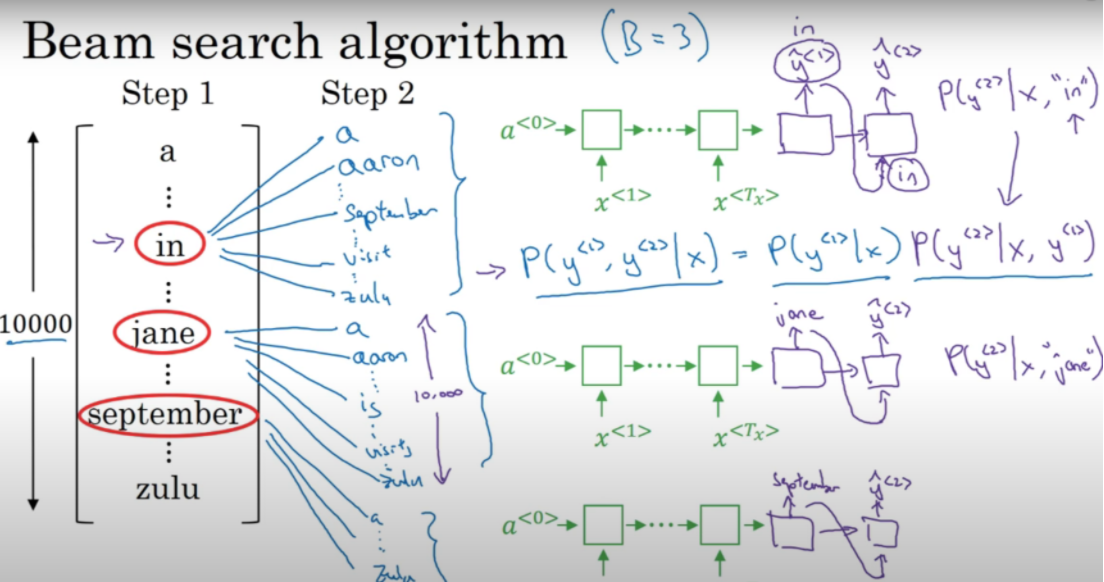

In beam search, we take the top k words as a possibility instead of the word with highest probability. In above pic, in step 1 we see three words - (in, jane, september) as three possible translated words that have the highest probability out of the 10,000 vocabulary of words.

In step 2, for each of the previous word, we pick another top 3 words with highest probability. But this probability calculation is now conditional to the previous word and is calculated based on the probability formula given in the picture.

But the probability calculation will be slightly modified by taking its negative log (log being monotonous will not impact the values; this trick makes the formula to add the probabilities instead of multiplying them to avoid underflow). See modified formula below -

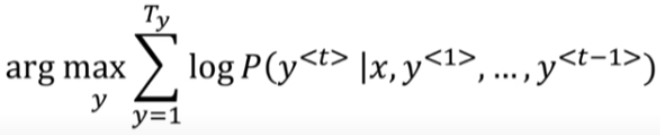

Once we have the 9 probabilities (k x k), we filter for the top 3 highest and then carry them forward to step 3 and so on.

One thing to note here is that there are k decoder models running here for reference for each word found in step 1. Let's discuss more about it with the pic below

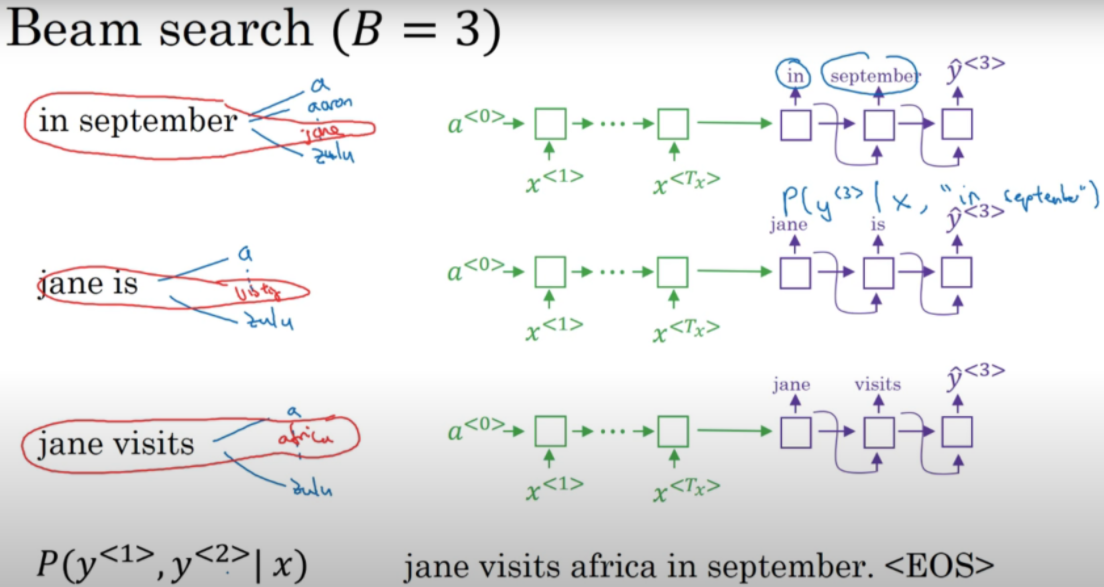

We see three decoder models that take the previous word as an input and then predicts the next word. Now some cases might arise here-

1. The top three probabilities might come out of one or two previous words and so the decoder model(s) that don't have the highest probability get cut off. This is advantageous as we are concerned with the highest conditional probability of the entire sentence.
2. A sentence progression can hit the 'end' signal before others and thus we get one possible translation of the sentence. The decoder model at this point might get cut off depending if it has more sequence progressions arising out of it.

Both cases above are considered in the algorithm formulation below. The above points also helps to understand the working behind Beam Search

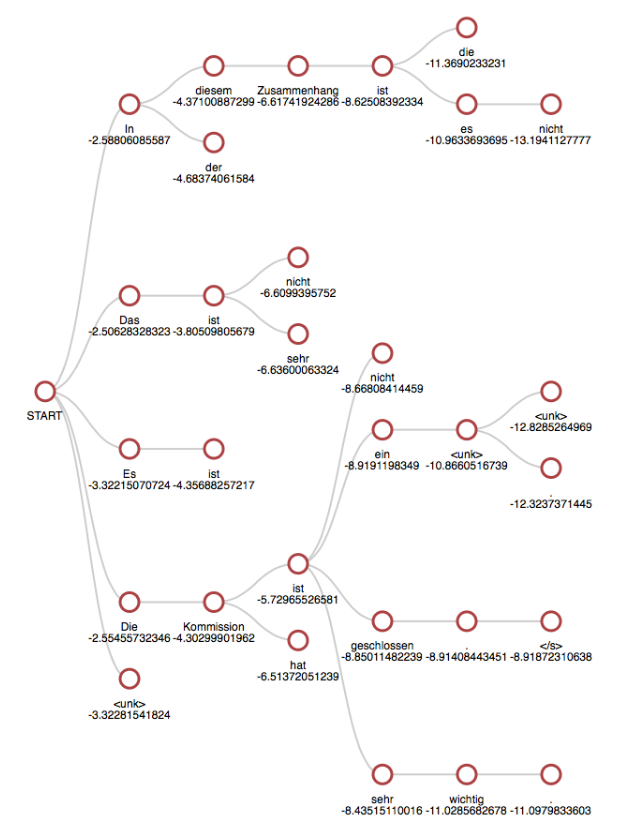

Above is an illustration of beam search with k=5 in translation to German. Notice 5 nodes at each vertical segment.

source:- https://medium.com/the-artificial-impostor/implementing-beam-search-part-1-4f53482daabe

In [31]:
# Function to get indices of k largest values in a 2-D matrix
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [32]:
# First function processing the Step-2 (that hits after Step-1)

def prelim_function_performing_beam_search(dec_hidden, pred_topk_word_ids, pred_topk_log_probs, enc_out, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combinations
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    
    # Run for k i.e. number of beam searches to produce
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, dec_hidden, enc_out)
        
        # append the hidden layers from this decoder (each word from step 2 will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)
    
    # Converting the lists to arrays for working with numpy functions
    word_ids_for_beam = np.array(word_ids_for_beam)
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]
    
    # The above sorting is a trick that will sort the first column values in ascending order and then the second column
    # so that one gets - [[0 2], [1 1]] and not [[1 1], [0 2]]

    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])
        
    # with the same logic, we store the word ids and their log probabilities to feed them to the next step

    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]
    
    
    # As we have new words now, we store them as sequences
    sequences = [[] for i in range(k)]
    
    for i, word_id in enumerate(pred_topk_word_ids):
        sequences[i].append(word_id)
    
    
    return sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k


In [33]:
# Second function processing all steps after Step-2

def function_performing_beam_search(hidden_ls, pred_topk_word_ids, pred_topk_log_probs, enc_out, passing_sequences, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combination
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    # Run for k (here k might not be equal to the original k as some sequences might have ended)
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer (its own)
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, hidden_ls[i], enc_out)
        
        # append the hidden layers from this decoder (each word will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)

        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)

    # Converting the lists to arrays for working with numpy functions
    
    word_ids_for_beam = np.array(word_ids_for_beam)    
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]

    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])

    # with the same logic, we store the word ids and their log probabilities to feed them to the next step
    
    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]


    # Now, we append the word_ids to the sequences we have to progress
    for i, word_id in enumerate(next_step_word_ids):
        passing_sequences[i].append(word_id)

    
    return passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k


In [34]:
# Helper function to convert the sequence of word-ids to words using the target language's tokenizer
def indices_to_sentences(indices):
    
    all_sentences = []
    
    for single_seq in indices:
        result = ''
        
        for i in single_seq[0][:-1]:
            result += tokenizer_output.index_word[i] + ' '
            
        all_sentences.append(result)
            
    return all_sentences

In [35]:
# Function to translate the sentence with beam search (k)

def evaluate_with_beam(sentence, k):

    # process the sentence first
    sentence = preprocessing_sentence(sentence)
        
    # Initialize lists to store all final sequences and their negative log probabilities
    final_sequences = [[] for i in range(k)]
    final_log_probs = [[] for i in range(k)]
    
    # transform the sentence to its tokenized form
    inputs = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    
    # Pad the tokenized inputs with 0
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=length_input,
                                                             padding='post')
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(inputs)
    
    # initialize hidden weights of encoder
    hidden = [tf.zeros([1, inp_lstm_cells]), tf.zeros([1, inp_lstm_cells])]
    
    # get the output of the encoder using initialized weights
    enc_out, enc_hidden = enc_model(inputs, hidden)

    # initialize decoder hidden weights same as encoder hidden weights
    dec_hidden = enc_hidden
    
    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer_output.word_index['start']], 0)
    
    ## Step-1 begins here
    
    # get the output of the encoder based on the outputs provided from encoder
    predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_out)
    # predictions shape = [1, tar_vocab_size]
    
    # Get the normalized predictions using Softmax
    pred_normalized = tf.nn.softmax(predictions)
    # pred_normalized shape = [1, tar_vocab_size]
    
    # Sort the predictions in descending order
    pred_normalized_sorted = tf.sort(pred_normalized, direction='DESCENDING').numpy()[0]
    # pred_normalized_sorted shape = [1, tar_vocab_size]
    
    # Converting normalized prediction to numpy data-type
    pred_normalized = pred_normalized.numpy()
    
    # Taking the top k predictions
    pred_topk_probs = pred_normalized_sorted[:k]
    
    # getting the word_ids of the tok k predictions based on their index positions
    pred_topk_word_ids = [np.argwhere(pred_normalized==x)[0][1] for x in pred_topk_probs]
    
    # Computing negative log probabilities of the first k predictions
    pred_topk_log_probs = -np.log(pred_normalized_sorted[:k])
    
    ## Step-2 begins here
    
    # Running the preliminary function after step-1
    sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = prelim_function_performing_beam_search(
                                                                    dec_hidden, pred_topk_word_ids, 
                                                                   pred_topk_log_probs, enc_out, k=k)
    
    # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
    end_outputs = []
    indices_to_cut = []
    
    for i, word_id in enumerate(next_step_word_ids):

        if tokenizer_output.index_word[word_id] == 'end':
            end_outputs.append(word_id)
            # Store the indices that we need to cut off
            indices_to_cut.append(i)
            
    # Creating a copy of existing sequences
    passing_sequences = sequences.copy()
    
    # Counter to point index of list to store
    finished_sequences_counter = 0
            
    # If 'end' is hit in one or more sequences
    if len(end_outputs) != 0:
        
        # For each indices that need to be cut
        for i in indices_to_cut:
            
            # First create a copy of passing sequences
            passing_seq_copy = passing_sequences.copy()
            
            # Append the final sequence and its negative log probability
            final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
            final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])
            
            # increase the counter by 1 to store another sequence at the next location
            finished_sequences_counter += 1
            
        # The sequences that end have to be removed from passing sequences to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del passing_sequences[ele] 
         
        # The sequences that end, their hidden layer has to be removed from passing to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del new_hidden_layers[ele] 
        
        # Reduce the number of k by the number of sequences that have ended
        k = k - len(end_outputs)
        
        # The word_ids for the next step also are stripped off of the ended sequence(s)
        next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
        
        # The negative log probs for the next step also are stripped off of the ended sequence(s)
        next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
    
    ## All steps after Step-2 begin here
    
    # Run this loop until all sequences are found
    while k > 0:
        
        # Running the function after step-2
        passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = function_performing_beam_search(
                                        new_hidden_layers, next_step_word_ids, 
                                       next_step_topk_log_probs, enc_out, passing_sequences, k=k)
    
        # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
        end_outputs = []
        indices_to_cut = []

        for i, word_id in enumerate(next_step_word_ids):

            if tokenizer_output.index_word[word_id] == 'end':
                end_outputs.append(word_id)
                indices_to_cut.append(i)

        # If 'end' is hit in one or more sequences
        if len(end_outputs) != 0:
            
            # For each indices that need to be cut
            for i in indices_to_cut:
                
                # First create a copy of passing sequences
                passing_seq_copy = passing_sequences.copy()
                
                # Append the final sequence and its negative log probability
                final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
                final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])

                # increase the counter by 1 to store another sequence at the next location
                finished_sequences_counter += 1
            
            # Reduce the number of k by the number of sequences that have ended
            k = k - len(end_outputs)
            
            # The sequences that end have to be removed from passing sequences to the next step           
            for ele in sorted(indices_to_cut, reverse = True):  
                del passing_sequences[ele] 
            
            # The sequences that end, their hidden layer has to be removed from passing to the next step
            for ele in sorted(indices_to_cut, reverse = True):  
                del new_hidden_layers[ele] 
            
            # The word_ids for the next step also are stripped off of the ended sequence(s)
            next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
            
            # The negative log probs for the next step also are stripped off of the ended sequence(s)
            next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)

    # Once out of the loop, all sequences have been found. Now, let's get the word from each word id to create sentences
    final_sentences = indices_to_sentences(final_sequences)
    
    # Print the sentences and their negative log probabilites (the lower the more probable)
    for i, sentence in enumerate(final_sentences):
        print("Translated Sentence {} : {}".format(i+1, sentence))
        print("Associated Neg Log Probability: {} \n".format(final_log_probs[i]))

In [36]:
evaluate_with_beam('this is coming good', 5)

Translated Sentence 1 : ca bien 
Associated Neg Log Probability: [1.9729928] 

Translated Sentence 2 : cela bien 
Associated Neg Log Probability: [2.8041842] 

Translated Sentence 3 : on bien 
Associated Neg Log Probability: [2.4277086] 

Translated Sentence 4 : ce bon 
Associated Neg Log Probability: [2.3943112] 

Translated Sentence 5 : c passe bien 
Associated Neg Log Probability: [2.5527287] 



In [37]:
evaluate_with_beam('You may speak', 5)

Translated Sentence 1 : vous discuter 
Associated Neg Log Probability: [0.7923796] 

Translated Sentence 2 : tu parler 
Associated Neg Log Probability: [2.2389612] 

Translated Sentence 3 : peut arreter 
Associated Neg Log Probability: [4.0256424] 

Translated Sentence 4 : il parler 
Associated Neg Log Probability: [1.5031487] 

Translated Sentence 5 : on courir 
Associated Neg Log Probability: [3.999619] 



In [38]:
evaluate_with_beam('it is very cold here', 5)

Translated Sentence 1 : c vraiment froid 
Associated Neg Log Probability: [1.4590162] 

Translated Sentence 2 : il tres froid ici 
Associated Neg Log Probability: [1.2284557] 

Translated Sentence 3 : on beaucoup beaucoup ici 
Associated Neg Log Probability: [2.4623508] 

Translated Sentence 4 : elle fort froid la bas 
Associated Neg Log Probability: [3.4176364] 

Translated Sentence 5 : son a tres la bas 
Associated Neg Log Probability: [3.54257] 



#### Section 6 - Evaluation of the Model

Any model has to be evaluated to know how good it is or to compare it with other models.

Machine translations is textual data and BLEU is a metric that can help to evaluate the translations with the correct translations that should be given. It is based on an n-gram model where it looks at the words appearing in the candidate translation with the reference translation. There are obvious limitations to this evaluation such as it will look at the word's and nearby words' positions only.

NLTK's bleu_score library gives this functionality. It looks at 1-gram to 4-gram and gives an average value (not exactly average) for how good the translations match with each other.

The below example shows a singular comparison using sentence_bleu. The reader can evaluate the model on test set using corplus_bleu. For more information, do refer nltk library and this article - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

In [42]:
from nltk.translate.bleu_score import sentence_bleu

# English sentence - 'it is very cold here'
reference = ['il fait vraiment froid ici'.split()] # Translation from Google

candidate = 'il tres froid ici'.split() # Best Translation from Model
# English version of French Translation above - 'it's very cold here'

score = sentence_bleu(reference, candidate)

print(score)

8.214546595247418e-155


In [43]:
reference, candidate

([['il', 'fait', 'vraiment', 'froid', 'ici']], ['il', 'tres', 'froid', 'ici'])

In [44]:
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.584101
Cumulative 2-gram: 0.389400
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000


We find that though the french translations are quite near to each other when translated back to english but BLEU score is quite low. BLEU ranges from 0(denoting no match) to 1(denoting perfect match). As stated earlier, this is a limitation of BLEU but it is still widely practiced as a metric to measure textual models' performances